## Requisitos

In [23]:
!pip install tensorflow
!pip install tensorflow-gpu
!pip install nvidia-cudnn-cu12
!pip install Pillow
!pip install scipy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install tf-explain
!pip install opencv-python
!pip install rembg
!pip install onnxruntime

# Rodar um 
# conda install -c conda-forge cudatoolkit

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      Traceback (most recent call last):
        File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/packaging/requirements.py", line 36, in __init__
          parsed = _parse_requirement(requirement_string)
        File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/packaging/_parser.py", line 62, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
        File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/packaging/_parser.py", line 80, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
        File "/home/vinmelo/Documents/Deep-

## Carregando os dados

### Data Augmentation

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
    samplewise_center=True,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2,
    horizontal_flip = True,
    vertical_flip = False
)
datagen_valid = ImageDataGenerator(
    samplewise_center=True,
    validation_split=0.2
)

2025-07-11 09:03:03.335964: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-11 09:03:03.552280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752235383.684371    5731 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752235383.731278    5731 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752235383.976725    5731 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Para avaliar os diferentes tipos de filtro, vamos carregar o data set de 7 formas:
- Variando cada crop com uma técnica de filtro
- Crop sem background

In [2]:
dir_used = ["crop_and_laplacian","crop_and_canny","crop_and_clahe","crop_and_scharr","crop_and_sharpening","crop_only", "removed_bg"]

train_dt = [datagen_train.flow_from_directory(
    f"./images/{dir_used[i]}/proporcional_resize/side",
    subset="training",
    seed=123,
    color_mode="rgb",
    target_size=(224,224),
    class_mode='binary',
) for i in range(7)]

valid_dt = [datagen_valid.flow_from_directory(
    f"./images/{dir_used[i]}/proporcional_resize/side",
    subset="validation",
    seed=123,
    color_mode="rgb",
    target_size=(224,224),
    class_mode='binary',
) for i in range(7)]

Found 144 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 142 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Found 35 images belonging to 2 classes.


## Modelo para Side
### Importando o Modelo pré treinado

In [3]:
from tensorflow import keras
base_model = keras.applications.EfficientNetB0(
    weights="imagenet",
    input_shape=(224,224,3),
    include_top=False
)

I0000 00:00:1752235394.990717    5731 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1403 MB memory:  -> device: 0, name: NVIDIA GeForce MX450, pci bus id: 0000:05:00.0, compute capability: 7.5


Congelando as primeiras camadas para treinarmos apenas as camada finais

In [4]:
base_model.trainable = False

### Adicionando camadas e compilando

In [5]:
inputs = keras.Input(shape=(224,224,3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)

outputs = keras.layers.Dense(1, activation= 'sigmoid')(x)

models = [keras.Model(inputs,outputs) for i in range(7)]
models

[<Functional name=functional, built=True>,
 <Functional name=functional_1, built=True>,
 <Functional name=functional_2, built=True>,
 <Functional name=functional_3, built=True>,
 <Functional name=functional_4, built=True>,
 <Functional name=functional_5, built=True>,
 <Functional name=functional_6, built=True>]

In [6]:
for i in range(7):
    models[i].compile(loss = 'binary_crossentropy', metrics=['accuracy','Precision','Recall', 'AUC'])

### Treinando o modelo para cada tipo de imagem

In [7]:
for i in range(7):
    models[i].fit(train_dt[i],
          validation_data=valid_dt[i],
          epochs=50)

/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1752235442.031051    7387 service.cc:152] XLA service 0x786880002b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752235442.031071    7387 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce MX450, Compute Capability 7.5
2025-07-11 09:04:02.395875: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752235444.076162    7387 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-07-11 09:04:13.409083: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-11 09:04:13.602672: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, plea

2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - AUC: 0.3774 - Precision: 0.3854 - Recall: 0.3258 - accuracy: 0.4453 - loss: 0.7837

2025-07-11 09:04:30.184667: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-11 09:04:30.352546: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-11 09:04:30.959127: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-11 09:04:31.139985: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-11 09:04:31.978851: E external/local_xla/xla/stream_

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 0.4168 - Precision: 0.4412 - Recall: 0.3757 - accuracy: 0.4721 - loss: 0.7630

2025-07-11 09:04:49.241114: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-11 09:04:49.393095: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-11 09:04:49.892948: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-11 09:04:50.057059: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-11 09:04:50.722353: E external/local_xla/xla/stream_

5/5 ━━━━━━━━━━━━━━━━━━━━ 59s 8s/step - AUC: 0.4252 - Precision: 0.4510 - Recall: 0.3825 - accuracy: 0.4767 - loss: 0.7588 - val_AUC: 0.5000 - val_Precision: 0.2500 - val_Recall: 0.0556 - val_accuracy: 0.4444 - val_loss: 0.7087
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 351ms/step - AUC: 0.5476 - Precision: 0.6127 - Recall: 0.6310 - accuracy: 0.5994 - loss: 0.6962 - val_AUC: 0.5231 - val_Precision: 0.2500 - val_Recall: 0.0556 - val_accuracy: 0.4444 - val_loss: 0.7055
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step - AUC: 0.6005 - Precision: 0.5945 - Recall: 0.5031 - accuracy: 0.5825 - loss: 0.6729 - val_AUC: 0.5586 - val_Precision: 0.6667 - val_Recall: 0.4444 - val_accuracy: 0.6111 - val_loss: 0.6843
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - AUC: 0.6051 - Precision: 0.6023 - Recall: 0.6591 - accuracy: 0.6002 - loss: 0.6776 - val_AUC: 0.6157 - val_Precision: 1.0000 - val_Recall: 0.1111 - val_accuracy: 0.5556 - val_loss: 0.6903
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step - A

2025-07-11 09:16:55.453303: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-11 09:16:55.617337: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-11 09:16:56.175455: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-11 09:16:56.357209: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-11 09:16:57.097777: E external/local_xla/xla/stream_

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 0.9397 - Precision: 0.8907 - Recall: 0.8807 - accuracy: 0.8709 - loss: 0.3300

2025-07-11 09:17:13.033747: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-11 09:17:13.183769: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-11 09:17:13.677572: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-11 09:17:13.845924: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-11 09:17:14.518550: E external/local_xla/xla/stream_

5/5 ━━━━━━━━━━━━━━━━━━━━ 45s 8s/step - AUC: 0.9395 - Precision: 0.8858 - Recall: 0.8774 - accuracy: 0.8690 - loss: 0.3291 - val_AUC: 0.9477 - val_Precision: 0.8095 - val_Recall: 0.9444 - val_accuracy: 0.8571 - val_loss: 0.3189
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step - AUC: 0.9559 - Precision: 0.9182 - Recall: 0.9234 - accuracy: 0.9141 - loss: 0.2782 - val_AUC: 0.9477 - val_Precision: 0.8095 - val_Recall: 0.9444 - val_accuracy: 0.8571 - val_loss: 0.3139
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 385ms/step - AUC: 0.9425 - Precision: 0.9007 - Recall: 0.8737 - accuracy: 0.8917 - loss: 0.3107 - val_AUC: 0.9477 - val_Precision: 0.8095 - val_Recall: 0.9444 - val_accuracy: 0.8571 - val_loss: 0.3136
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - AUC: 0.9256 - Precision: 0.8657 - Recall: 0.9157 - accuracy: 0.8794 - loss: 0.3457 - val_AUC: 0.9477 - val_Precision: 0.8095 - val_Recall: 0.9444 - val_accuracy: 0.8571 - val_loss: 0.3076
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 373ms/step - A

### Avaliando os modelos

#### Acurácia

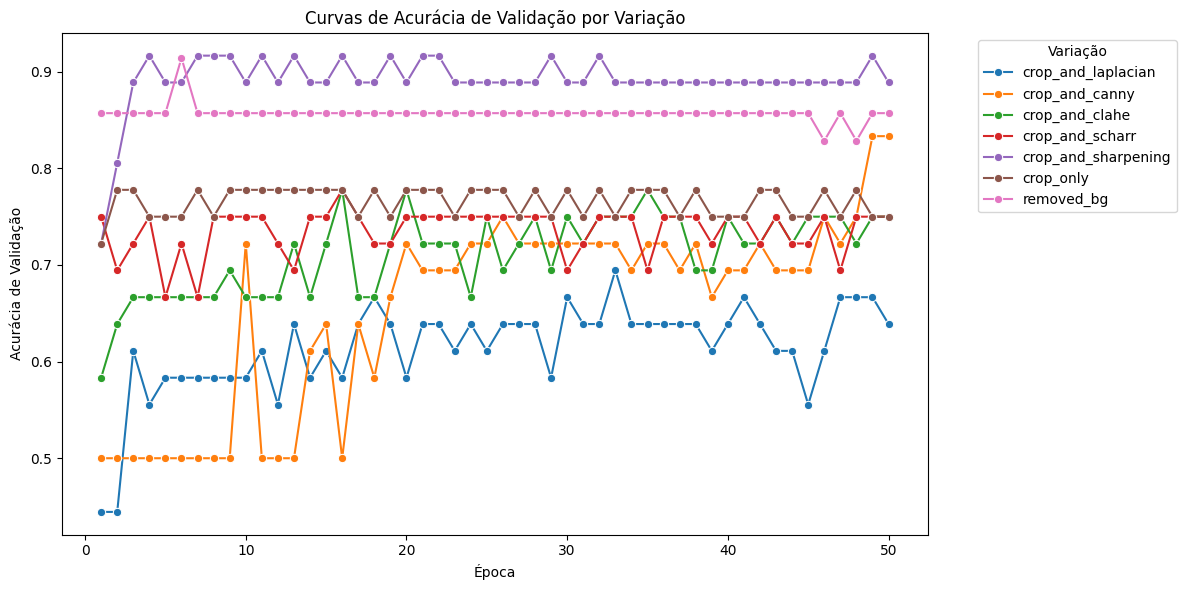

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Constrói uma tabela com: época, acurácia, nome da variação
data = []

for model, name in zip(models, dir_used):
    val_accuracies = model.history.history['val_accuracy']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Acurácia de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Acurácia de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### AUC (Area under the curve)

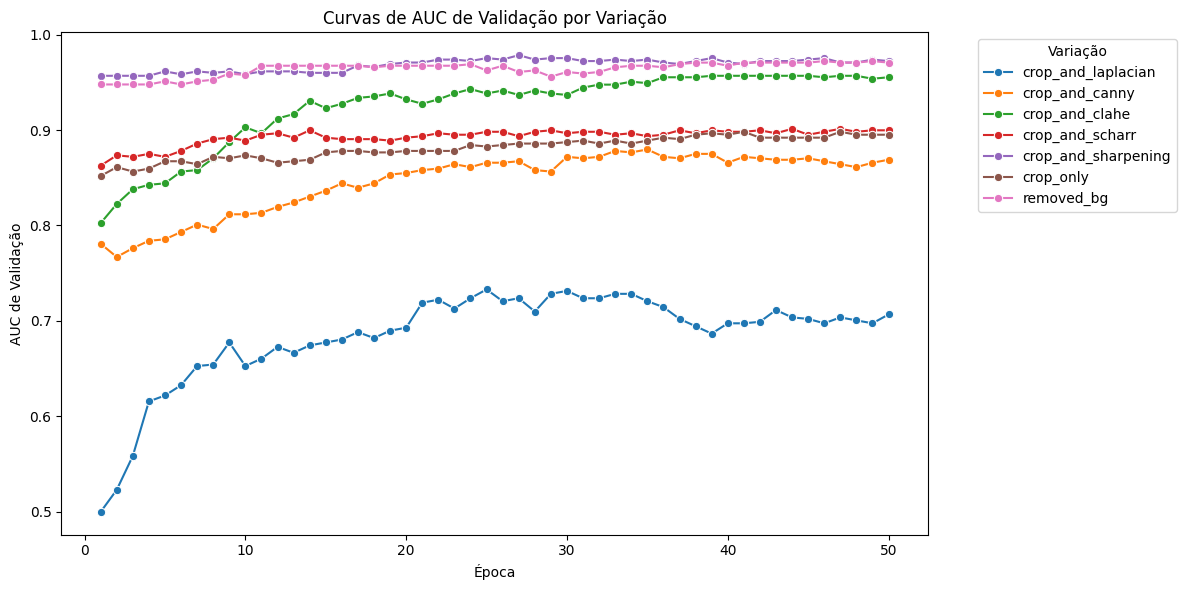

In [9]:
data = []

for model, name in zip(models, dir_used):
    val_accuracies = model.history.history['val_AUC']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de AUC de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("AUC de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Precision

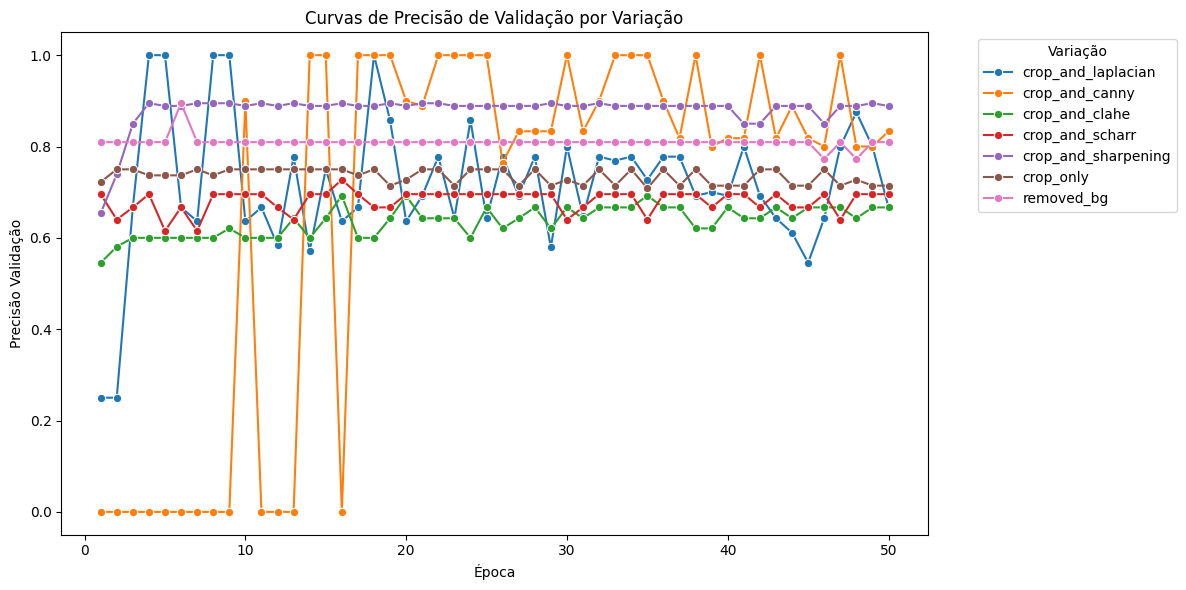

In [10]:
data = []

for model, name in zip(models, dir_used):
    val_accuracies = model.history.history['val_Precision']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Precisão de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Precisão Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Recall

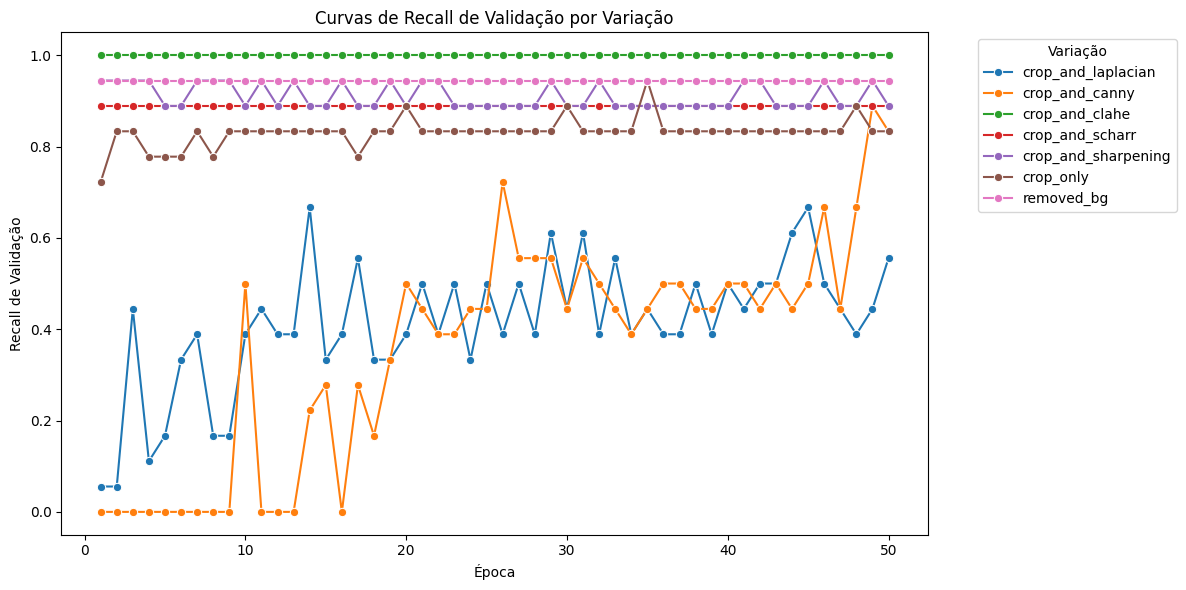

In [11]:
data = []

for model, name in zip(models, dir_used):
    val_accuracies = model.history.history['val_Recall']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Recall de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Recall de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

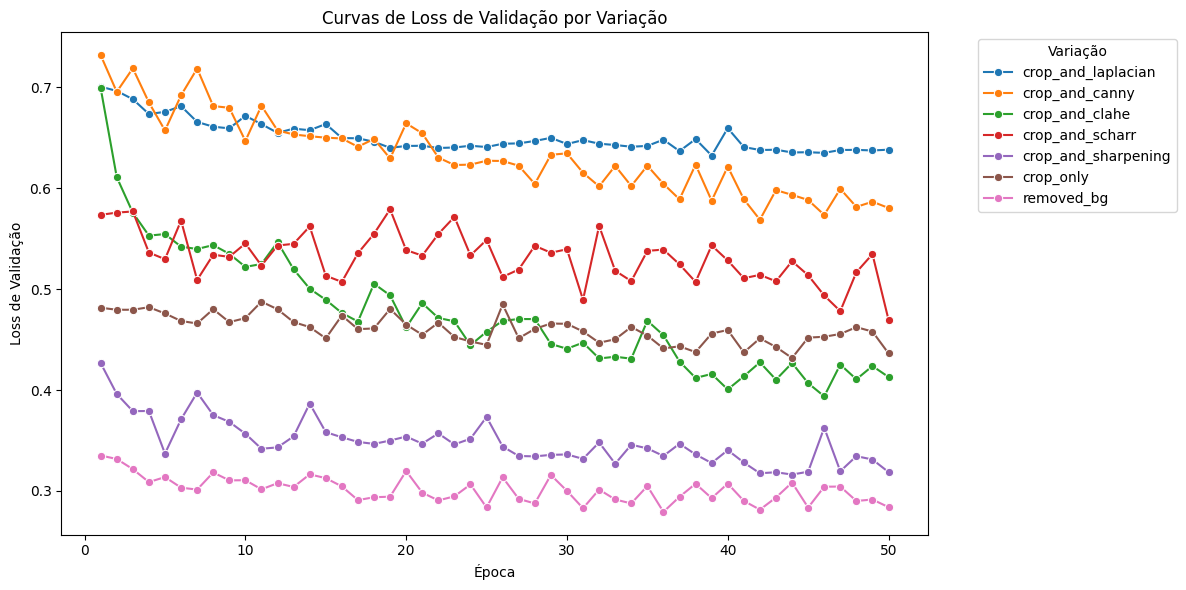

In [14]:
data = []

for model, name in zip(models, dir_used):
    val_accuracies = model.history.history['val_loss']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Loss de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Loss de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [35]:
models[4].history.history['val_accuracy'][-1]
models[4].save('side-transfer.keras')
models[6].save('side-teste.keras')

In [34]:
models[4].save('transfer-learning_side.keras')

## Modelo para top

### Importando o modelo VGG16

In [23]:
from tensorflow import keras

base_model_top = keras.applications.VGG16(
    weights="imagenet",
    input_shape=(224,224,3),
    include_top=False
)

base_model_top.trainable = False

### Adicionando camadas e compilando

In [24]:
inputs_top = keras.Input(shape=(224,224,3))

x_top = base_model_top(inputs_top, training=False)
x_top = keras.layers.GlobalAveragePooling2D()(x_top)

outputs_top = keras.layers.Dense(1, activation= 'sigmoid')(x_top)

models_top = [keras.Model(inputs_top,outputs_top) for i in range(7)]
models_top

[<Functional name=functional_7, built=True>,
 <Functional name=functional_8, built=True>,
 <Functional name=functional_9, built=True>,
 <Functional name=functional_10, built=True>,
 <Functional name=functional_11, built=True>,
 <Functional name=functional_12, built=True>,
 <Functional name=functional_13, built=True>]

In [25]:
for i in range(7):
    models_top[i].compile(loss = 'binary_crossentropy', metrics=['accuracy','Precision','Recall', 'AUC'])

### Treinando o modelo

In [26]:
for i in range(7):
    models_top[i].fit(train_dt[i],
              validation_data=valid_dt[i],
              epochs=50)

Epoch 1/50


2025-07-11 09:35:27.555226: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.39 = (f32[32,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0} %bitcast.1458, f32[64,3,3,3]{3,2,1,0} %bitcast.1465, f32[64]{0} %bitcast.1467), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_7_1/vgg16_1/block1_conv1_1/convolution" source_file="/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-11 09:35:27.736751: W external/local_xla/xla/tsl/fr

1/5 ━━━━━━━━━━━━━━━━━━━━ 1:47 27s/step - AUC: 0.5142 - Precision: 0.2000 - Recall: 0.0769 - accuracy: 0.5000 - loss: 3.2635

2025-07-11 09:35:52.605607: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.39 = (f32[16,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,224,224]{3,2,1,0} %bitcast.1458, f32[64,3,3,3]{3,2,1,0} %bitcast.1465, f32[64]{0} %bitcast.1467), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_7_1/vgg16_1/block1_conv1_1/convolution" source_file="/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-11 09:35:52.832841: I external/local_xla/xla/servic

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 0.4890 - Precision: 0.3449 - Recall: 0.1600 - accuracy: 0.4984 - loss: 2.8371

2025-07-11 09:36:10.494716: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.39 = (f32[4,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,3,224,224]{3,2,1,0} %bitcast.1203, f32[64,3,3,3]{3,2,1,0} %bitcast.1210, f32[64]{0} %bitcast.1212), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_7_1/vgg16_1/block1_conv1_1/convolution" source_file="/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-11 09:36:11.042228: I external/local_xla/xla/service/

5/5 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - AUC: 0.4866 - Precision: 0.3606 - Recall: 0.1750 - accuracy: 0.4929 - loss: 2.8092 - val_AUC: 0.3025 - val_Precision: 0.4118 - val_Recall: 0.3889 - val_accuracy: 0.4167 - val_loss: 2.3008
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 592ms/step - AUC: 0.3979 - Precision: 0.4040 - Recall: 0.4184 - accuracy: 0.4237 - loss: 2.1928 - val_AUC: 0.3086 - val_Precision: 0.3750 - val_Recall: 0.3333 - val_accuracy: 0.3889 - val_loss: 2.0878
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step - AUC: 0.4096 - Precision: 0.4314 - Recall: 0.4251 - accuracy: 0.4263 - loss: 1.8551 - val_AUC: 0.3056 - val_Precision: 0.2500 - val_Recall: 0.1667 - val_accuracy: 0.3333 - val_loss: 2.0408
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 601ms/step - AUC: 0.4890 - Precision: 0.4891 - Recall: 0.4729 - accuracy: 0.4818 - loss: 1.5711 - val_AUC: 0.3302 - val_Precision: 0.2000 - val_Recall: 0.1111 - val_accuracy: 0.3333 - val_loss: 1.8893
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 607ms/step - A

2025-07-11 09:58:31.928692: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.39 = (f32[14,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[14,3,224,224]{3,2,1,0} %bitcast.1458, f32[64,3,3,3]{3,2,1,0} %bitcast.1465, f32[64]{0} %bitcast.1467), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_13_1/vgg16_1/block1_conv1_1/convolution" source_file="/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-11 09:58:32.170663: I external/local_xla/xla/servi

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - AUC: 0.8823 - Precision: 0.8431 - Recall: 0.7238 - accuracy: 0.7746 - loss: 0.5145

2025-07-11 09:58:56.246160: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.46 = (f32[3,512,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[3,256,28,28]{3,2,1,0} %bitcast.1305, f32[512,256,3,3]{3,2,1,0} %bitcast.1312, f32[512]{0} %bitcast.1314), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_13_1/vgg16_1/block4_conv1_1/convolution" source_file="/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-11 09:58:56.881808: I external/local_xla/xla/serv

5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 7s/step - AUC: 0.8874 - Precision: 0.8436 - Recall: 0.7305 - accuracy: 0.7805 - loss: 0.4960 - val_AUC: 0.8693 - val_Precision: 0.7273 - val_Recall: 0.8889 - val_accuracy: 0.7714 - val_loss: 0.5469
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 844ms/step - AUC: 0.8980 - Precision: 0.8266 - Recall: 0.8329 - accuracy: 0.8328 - loss: 0.4289 - val_AUC: 0.8758 - val_Precision: 0.7273 - val_Recall: 0.8889 - val_accuracy: 0.7714 - val_loss: 0.5669
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 955ms/step - AUC: 0.8948 - Precision: 0.7977 - Recall: 0.9138 - accuracy: 0.8269 - loss: 0.4110 - val_AUC: 0.8725 - val_Precision: 0.7619 - val_Recall: 0.8889 - val_accuracy: 0.8000 - val_loss: 0.5122
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 903ms/step - AUC: 0.9370 - Precision: 0.8211 - Recall: 0.8822 - accuracy: 0.8441 - loss: 0.3327 - val_AUC: 0.8725 - val_Precision: 0.7619 - val_Recall: 0.8889 - val_accuracy: 0.8000 - val_loss: 0.5269
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 853ms/step - A

### Acurácia

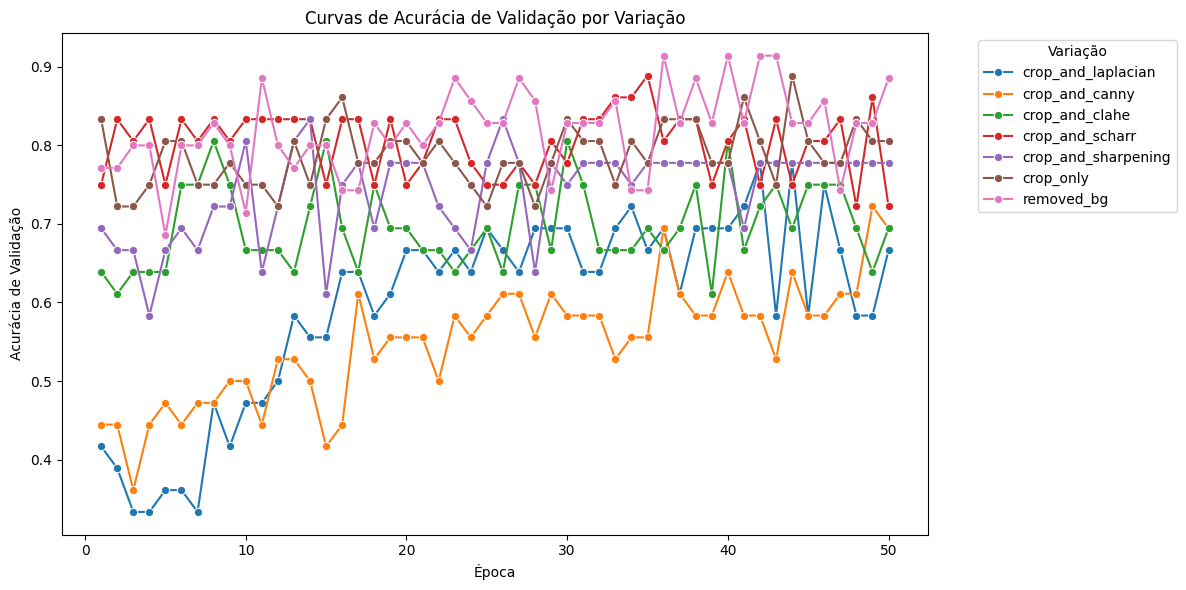

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Constrói uma tabela com: época, acurácia, nome da variação
data = []

for model, name in zip(models_top, dir_used):
    val_accuracies = model.history.history['val_accuracy']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Acurácia de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Acurácia de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### AUC

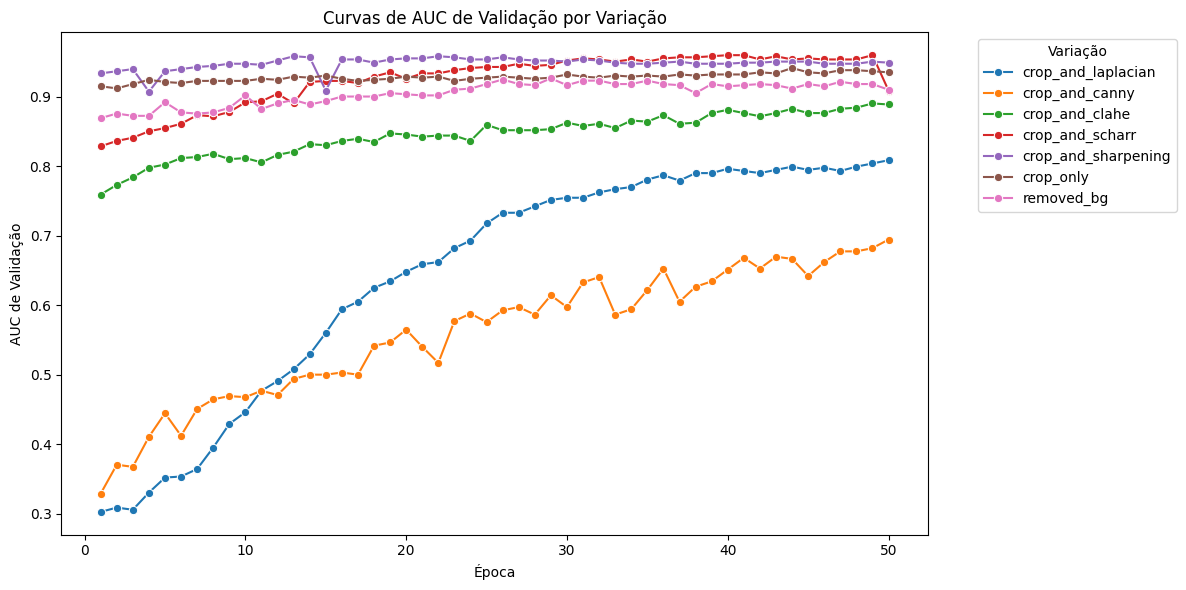

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Constrói uma tabela com: época, acurácia, nome da variação
data = []

for model, name in zip(models_top, dir_used):
    val_accuracies = model.history.history['val_AUC']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de AUC de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("AUC de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Precision

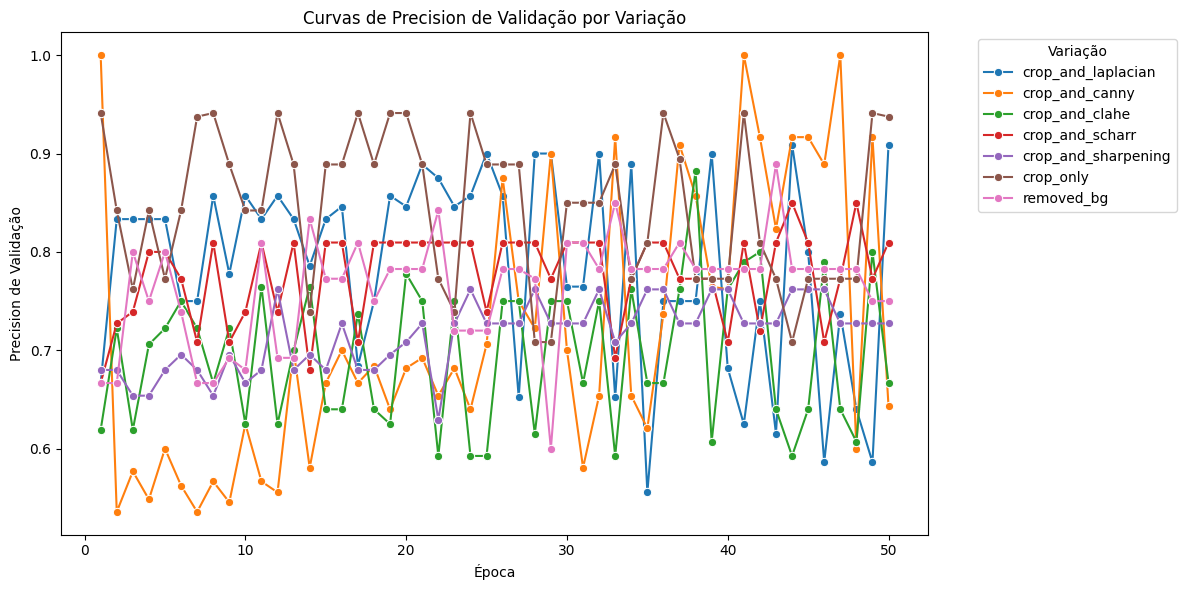

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Constrói uma tabela com: época, acurácia, nome da variação
data = []

for model, name in zip(models_top, dir_used):
    val_accuracies = model.history.history['val_Precision']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Precision de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Precision de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Recall

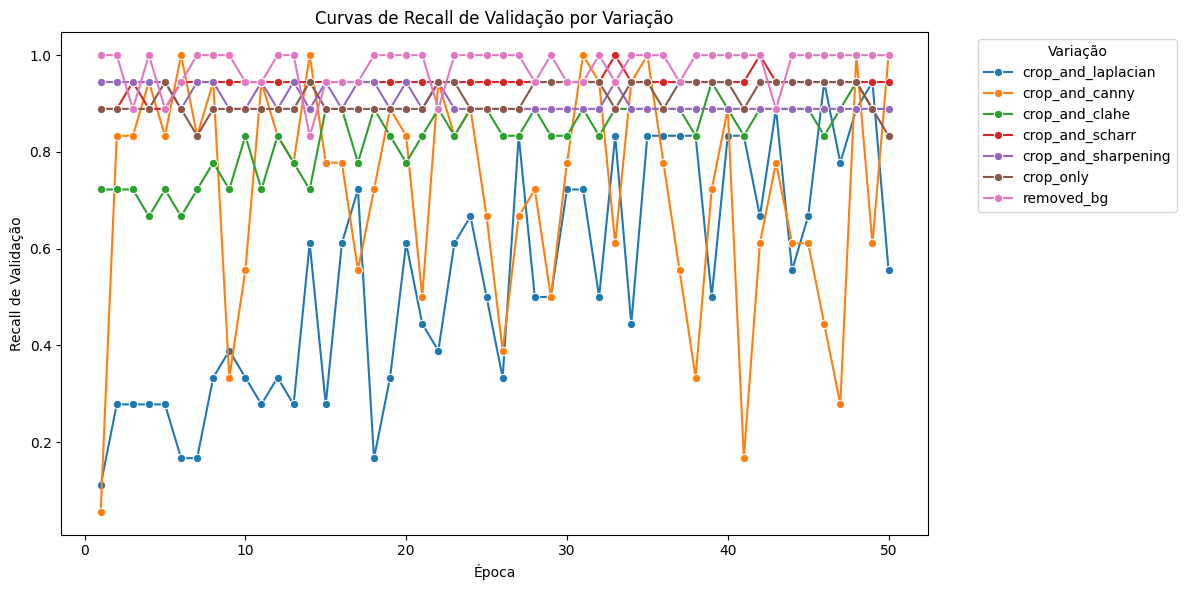

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Constrói uma tabela com: época, acurácia, nome da variação
data = []

for model, name in zip(models_top, dir_used):
    val_accuracies = model.history.history['val_Recall']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Recall de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Recall de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

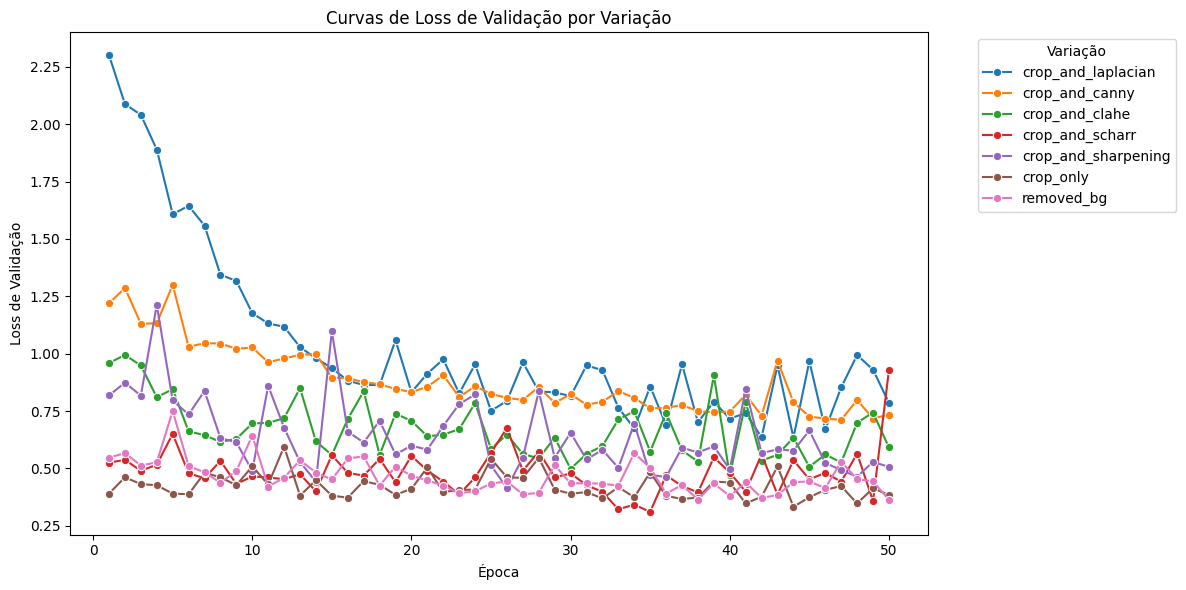

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Constrói uma tabela com: época, acurácia, nome da variação
data = []

for model, name in zip(models_top, dir_used):
    val_accuracies = model.history.history['val_loss']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Loss de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Loss de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [19]:
models_top[3].save('transfer-learning_top.keras')

## Interpretabilidade

Pré processamento da imagem de teste

In [12]:
import cv2
import numpy as np
from PIL import Image
import os

def apply_sharpening(input_path: str, output_path: str):
    try:
        # Lê a imagem de entrada
        image = crop_box_and_return_image(input_path)
        if image is None:
            print(f"  [ERRO] Não foi possível ler o arquivo: {input_path}")
            return False

        # Define o kernel de nitidez com o valor fixo de 8.5
        sharpening_kernel = np.array([
            [-1, -1, -1],
            [-1, 8.5, -1],
            [-1, -1, -1]
        ], dtype=np.float32)

        # Aplica o filtro de convolução
        sharpened_image = cv2.filter2D(image, -1, sharpening_kernel)
        
        # Salva a imagem resultante
        cv2.imwrite(output_path, sharpened_image)
        return True

    except Exception as e:
        print(f"  [ERRO] Ocorreu uma exceção ao processar '{input_path}': {e}")
        return False
    
def proportional_resize_with_padding(input_path: str, output_path: str, canvas_size: tuple = (244, 244)):
    try:
        # Abre a imagem original
        original_img = Image.open(input_path)

        # Garante que a imagem esteja em modo RGB, tratando a transparência
        rgb_img = Image.new("RGB", original_img.size, (0, 0, 0))
        rgb_img.paste(original_img, mask=original_img.getchannel('A') if original_img.mode == 'RGBA' else None)

        # Calcula a proporção para o novo tamanho sem distorcer
        ratio = min((canvas_size[0] / rgb_img.width), (canvas_size[1] / rgb_img.height))
        new_width = int(rgb_img.width * ratio)
        new_height = int(rgb_img.height * ratio)

        # Redimensiona a imagem mantendo a proporção
        resized_img = rgb_img.resize((new_width, new_height), Image.Resampling.LANCZOS)
        
        # Cria o canvas final com fundo preto
        black_canvas = Image.new('RGB', canvas_size, (0, 0, 0))

        # Calcula a posição para colar a imagem redimensionada no centro do canvas
        paste_x = (canvas_size[0] - new_width) // 2
        paste_y = (canvas_size[1] - new_height) // 2

        # Cola a imagem redimensionada no canvas
        black_canvas.paste(resized_img, (paste_x, paste_y))

        # Salva a imagem final
        black_canvas.save(output_path)
        print(f"Imagem redimensionada (proporcional) e salva em: {output_path}")

    except FileNotFoundError:
        print(f"Erro: O arquivo de entrada não foi encontrado em '{input_path}'")
        input()
    except Exception as e:
        print(f"Ocorreu um erro: {e}")
        input()

def crop_box_and_return_image(image_path):
    """
    Processa uma única imagem e retorna o objeto da imagem recortada, ou None se falhar.
    """
    
    MARGEM_X = 15
    MARGEM_Y = 15
    BLUR_KERNEL = 5
    CONTRASTE_ALPHA = 1.2
    BRILHO_BETA = -50
    SATURACAO_FACTOR = 2.4
    MORPH_KERNEL = 7
    MORPH_ITERATIONS = 0
    LOWER_CYAN = np.array([48, 0, 100])
    UPPER_CYAN = np.array([104, 255, 255])
    LOWER_WHITE = np.array([0, 0, 160])
    UPPER_WHITE = np.array([176, 60, 255])

    image = cv2.imread(image_path)
    if image is None:
        print(f"  [ERRO] Não foi possível carregar a imagem: {image_path}")
        return None

    img_h, img_w = image.shape[:2]

    # --- Pipeline de Processamento ---
    processed_image = image.copy()
    if BLUR_KERNEL > 1:
        processed_image = cv2.GaussianBlur(processed_image, (BLUR_KERNEL, BLUR_KERNEL), 0)
    processed_image = cv2.convertScaleAbs(processed_image, alpha=CONTRASTE_ALPHA, beta=BRILHO_BETA)
    hsv_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    s = np.clip(s * SATURACAO_FACTOR, 0, 255).astype(np.uint8)
    final_hsv = cv2.merge([h, s, v])
    mask_cyan = cv2.inRange(final_hsv, LOWER_CYAN, UPPER_CYAN)
    mask_white = cv2.inRange(final_hsv, LOWER_WHITE, UPPER_WHITE)
    final_mask = cv2.bitwise_or(mask_cyan, mask_white)

    if MORPH_KERNEL > 1 and MORPH_ITERATIONS > 0:
        kernel = np.ones((MORPH_KERNEL, MORPH_KERNEL), np.uint8)
        final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, kernel, iterations=MORPH_ITERATIONS)
    
    # --- Encontrar e Recortar o Contorno ---
    contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print(f"  [AVISO] Nenhum contorno encontrado para: {os.path.basename(image_path)}")
        return None
        
    final_contour = max(contours, key=cv2.contourArea)

    # --- Calcular Bounding Box e Adicionar Margem ---
    x, y, w, h = cv2.boundingRect(final_contour)
    x_start = max(0, x - MARGEM_X)
    y_start = max(0, y - MARGEM_Y)
    x_end = min(img_w, x + w + MARGEM_X)
    y_end = min(img_h, y + h + MARGEM_Y)
    
    # Retorna a imagem recortada
    return image[y_start:y_end, x_start:x_end]

#### Model side

Imagem redimensionada (proporcional) e salva em: resize_test.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


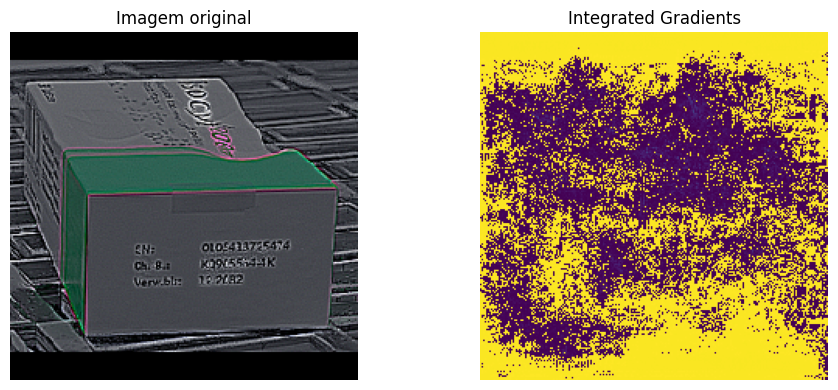

In [14]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from tf_explain.core.integrated_gradients import IntegratedGradients

# 1. Pré-processamento da imagem
img_path = "dataset-desafio/interpretabilidade/side/damaged/0105413725474_side.png"

apply_sharpening(img_path, "test.png")
proportional_resize_with_padding("test.png", "resize_test.png")

img = load_img("resize_test.png", target_size=(224, 224))
img_array = img_to_array(img)

# Aplicar samplewise_center, igual no seu generator
img_array -= np.mean(img_array, keepdims=True)
img_array = np.expand_dims(img_array, axis=0)

# 2. Carregar o modelo
model_side = models[4]  # Ou load_model("seu_modelo.keras")
pred = model_side.predict(img_array)
class_index = np.argmax(pred)

# 3. Criar o explicador Integrated Gradients
explainer = IntegratedGradients()

# 4. Executar a explicação
explanation = explainer.explain((img_array, None), model_side, class_index=class_index)

# 5. Mostrar resultados

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Imagem original")
plt.imshow(np.array(img).astype(np.uint8))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Integrated Gradients")
plt.imshow(explanation)
plt.axis("off")

plt.tight_layout()
plt.show()


In [15]:
from rembg import new_session, remove

def remove_background(
    image_path: str,
    output_filename: str,
    padding: int = 30
):
    """
    Carrega uma imagem de um caminho,
    aplica o processo refinado de remoção de fundo e salva o resultado.
    """
    # Carrega a imagem a partir do caminho
    input_image = crop_box_and_return_image(image_path)
    if input_image is None:
        print(f"    [ERRO] Não foi possível carregar a imagem: {image_path}")
        return

    h_orig, w_orig = input_image.shape[:2]
    session = new_session("isnet-general-use")

    # --- Motor de Detecção (Passos 1-4) ---
    mask_pass1 = remove(input_image, session=session, only_mask=True)
    lab_clahe = cv2.cvtColor(input_image, cv2.COLOR_BGR2LAB)
    l_clahe, a_clahe, b_clahe = cv2.split(lab_clahe)
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(2, 2))
    cl = clahe.apply(l_clahe)
    merged_lab_clahe = cv2.merge([cl, a_clahe, b_clahe])
    enhanced_image_clahe = cv2.cvtColor(merged_lab_clahe, cv2.COLOR_LAB2BGR)
    mask_pass2 = remove(enhanced_image_clahe, session=session, only_mask=True)
    lab_bright = cv2.cvtColor(input_image, cv2.COLOR_BGR2LAB)
    l_bright, a_bright, b_bright = cv2.split(lab_bright)
    l_boosted = np.where(cv2.inRange(l_bright, 180, 255) == 255, 255, l_bright)
    merged_lab_bright = cv2.merge([l_boosted, a_bright, b_bright])
    enhanced_image_bright = cv2.cvtColor(merged_lab_bright, cv2.COLOR_LAB2BGR)
    mask_pass3 = remove(enhanced_image_bright, session=session, only_mask=True)
    hls = cv2.cvtColor(input_image, cv2.COLOR_BGR2HLS)
    mask_pass4 = cv2.inRange(hls, np.array([0, 180, 0]), np.array([255, 255, 40]))

    # --- Combinação e Calibração Final (Passo 5) ---
    combined_mask_ia = cv2.bitwise_or(cv2.bitwise_or(mask_pass1, mask_pass2), mask_pass3)
    final_combined_mask = cv2.bitwise_or(combined_mask_ia, mask_pass4)
    dilated_mask = cv2.dilate(final_combined_mask, np.ones((7, 7), np.uint8), iterations=4)

    contours, _ = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print(f"    [ERRO] Nenhum contorno encontrado após dilatação.")
        return

    mask_reconstruida = np.zeros((h_orig, w_orig), dtype=np.uint8)
    significant_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 10]
    for contour in significant_contours:
        cv2.drawContours(mask_reconstruida, [contour], -1, 255, thickness=cv2.FILLED)

    eroded_mask = cv2.erode(mask_reconstruida, np.ones((5, 5), np.uint8), iterations=7)
    mask_final = cv2.dilate(eroded_mask, np.ones((3, 3), np.uint8), iterations=6)

    # --- Aplicar Máscara e Salvar ---
    b, g, r = cv2.split(input_image)
    final_rgba_image = cv2.merge([b, g, r, mask_final])

    final_contours, _ = cv2.findContours(mask_final, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not final_contours:
        final_cropped_image = final_rgba_image
    else:
        x_coords, y_coords = [], []
        for contour in final_contours:
            x, y, w, h = cv2.boundingRect(contour)
            x_coords.extend([x, x + w])
            y_coords.extend([y, y + h])

        x_start = max(0, min(x_coords) - padding)
        y_start = max(0, min(y_coords) - padding)
        x_end = min(w_orig, max(x_coords) + padding)
        y_end = min(h_orig, max(y_coords) + padding)
        final_cropped_image = final_rgba_image[y_start:y_end, x_start:x_end]

    cv2.imwrite(output_filename, final_cropped_image)
    print(f"  -> Sucesso! Resultado final salvo.")

  -> Sucesso! Resultado final salvo.
Imagem redimensionada (proporcional) e salva em: resize_test.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


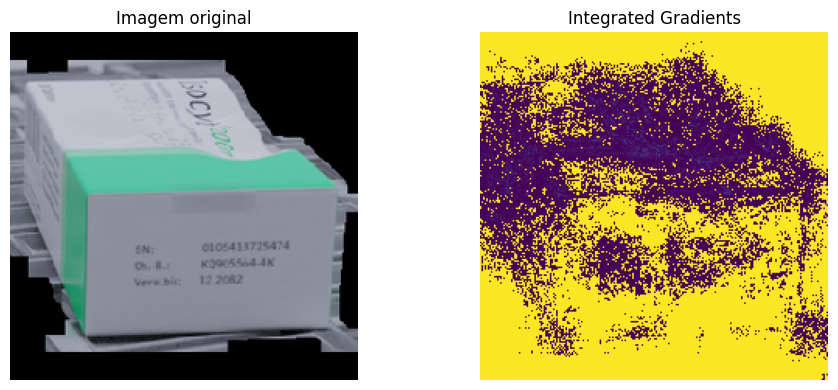

In [16]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from tf_explain.core.integrated_gradients import IntegratedGradients

# 1. Pré-processamento da imagem
img_path = "dataset-desafio/interpretabilidade/side/damaged/0105413725474_side.png"

remove_background(img_path, "test.png")
proportional_resize_with_padding("test.png", "resize_test.png")

img = load_img("resize_test.png", target_size=(224, 224))
img_array = img_to_array(img)

# Aplicar samplewise_center, igual no seu generator
img_array -= np.mean(img_array, keepdims=True)
img_array = np.expand_dims(img_array, axis=0)

# 2. Carregar o modelo
model_side = models[6]  # Ou load_model("seu_modelo.keras")
pred = model_side.predict(img_array)
class_index = np.argmax(pred)

# 3. Criar o explicador Integrated Gradients
explainer = IntegratedGradients()

# 4. Executar a explicação
explanation = explainer.explain((img_array, None), model_side, class_index=class_index)

# 5. Mostrar resultados

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Imagem original")
plt.imshow(np.array(img).astype(np.uint8))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Integrated Gradients")
plt.imshow(explanation)
plt.axis("off")

plt.tight_layout()
plt.show()


Isso nos deixa claro que o método de remover bg é mais efetivo, e está considerando os elementos corretos

#### Modelo para top

In [20]:
def crop_box_top_and_return_image(image_path):
    """
    Processa uma única imagem e retorna o objeto da imagem recortada, ou None se falhar.
    """
    
    MARGEM_X = 15
    MARGEM_Y = 15
    BLUR_KERNEL = 5
    CONTRASTE_ALPHA = 1.2
    BRILHO_BETA = -50
    SATURACAO_FACTOR = 2.4
    MORPH_KERNEL = 7
    MORPH_ITERATIONS = 0
    LOWER_CYAN = np.array([48, 0, 100])
    UPPER_CYAN = np.array([104, 255, 255])
    LOWER_WHITE = np.array([0, 0, 160])
    UPPER_WHITE = np.array([176, 60, 255])

    image = cv2.imread(image_path)
    if image is None:
        print(f"  [ERRO] Não foi possível carregar a imagem: {image_path}")
        return None

    img_h, img_w = image.shape[:2]

    # --- Pipeline de Processamento ---
    processed_image = image.copy()
    if BLUR_KERNEL > 1:
        processed_image = cv2.GaussianBlur(processed_image, (BLUR_KERNEL, BLUR_KERNEL), 0)
    processed_image = cv2.convertScaleAbs(processed_image, alpha=CONTRASTE_ALPHA, beta=BRILHO_BETA)
    hsv_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    s = np.clip(s * SATURACAO_FACTOR, 0, 255).astype(np.uint8)
    final_hsv = cv2.merge([h, s, v])
    mask_cyan = cv2.inRange(final_hsv, LOWER_CYAN, UPPER_CYAN)
    mask_white = cv2.inRange(final_hsv, LOWER_WHITE, UPPER_WHITE)
    final_mask = cv2.bitwise_or(mask_cyan, mask_white)

    if MORPH_KERNEL > 1 and MORPH_ITERATIONS > 0:
        kernel = np.ones((MORPH_KERNEL, MORPH_KERNEL), np.uint8)
        final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, kernel, iterations=MORPH_ITERATIONS)
    
    # --- Encontrar e Recortar o Contorno ---
    contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print(f"  [AVISO] Nenhum contorno encontrado para: {os.path.basename(image_path)}")
        return None
        
    final_contour = max(contours, key=cv2.contourArea)

    # --- Calcular Bounding Box e Adicionar Margem ---
    x, y, w, h = cv2.boundingRect(final_contour)
    x_start = max(0, x - MARGEM_X)
    y_start = max(0, y - MARGEM_Y)
    x_end = min(img_w, x + w + MARGEM_X)
    y_end = min(img_h, y + h + MARGEM_Y)
    
    # Retorna a imagem recortada
    return image[y_start:y_end, x_start:x_end]

Imagem redimensionada (proporcional) e salva em: resize_test.png


2025-07-11 10:04:50.550099: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.46 = (f32[1,512,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,256,28,28]{3,2,1,0} %bitcast.587, f32[512,256,3,3]{3,2,1,0} %bitcast.594, f32[512]{0} %bitcast.596), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_12_1/vgg16_1/block4_conv1_1/convolution" source_file="/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-11 10:04:51.237907: I external/local_xla/xla/service

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


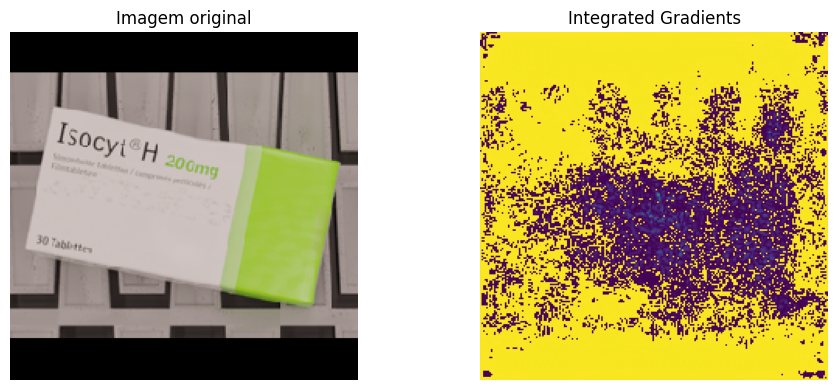

In [30]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from tf_explain.core.integrated_gradients import IntegratedGradients

# 1. Pré-processamento da imagem
img_path = "dataset-desafio/interpretabilidade/top/damaged/0105413725474_top.png"

temp_arr = crop_box_top_and_return_image(img_path)
temp_pil = Image.fromarray(temp_arr)
temp_pil.save("test.png")
proportional_resize_with_padding("test.png", "resize_test.png")

img = load_img("resize_test.png", target_size=(224, 224))
img_array = img_to_array(img)

# Aplicar samplewise_center, igual no seu generator
img_array -= np.mean(img_array, keepdims=True)
img_array = np.expand_dims(img_array, axis=0)

# 2. Carregar o modelo
model_top = models_top[5]  # Ou load_model("seu_modelo.keras")
pred = model_top.predict(img_array)
class_index = np.argmax(pred)

# 3. Criar o explicador Integrated Gradients
explainer = IntegratedGradients()

# 4. Executar a explicação
explanation = explainer.explain((img_array, None), model_top, class_index=class_index)

# 5. Mostrar resultados

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Imagem original")
plt.imshow(np.array(img).astype(np.uint8))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Integrated Gradients")
plt.imshow(explanation)
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import os
from PIL import Image
import numpy as np

def preprocess_test(input_dir, output_dir):
    # Certifica-se de que o diretório de saída existe
    os.makedirs(output_dir, exist_ok=True)

    for root, _, files in os.walk(input_dir):
        for fname in files:
            if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                input_path = os.path.join(root, fname)

                # Gera o caminho relativo e monta o novo caminho de saída
                rel_path = os.path.relpath(input_path, input_dir)
                output_path = os.path.join(output_dir, rel_path)

                # Cria subdiretórios, se necessário
                os.makedirs(os.path.dirname(output_path), exist_ok=True)

                # ====== PREPROCESSAMENTO ======
                img_arr = crop_box_top_and_return_image(input_path)

                # Se for array, converte para PIL
                if isinstance(img_arr, np.ndarray):
                    img = Image.fromarray(img_arr)
                else:
                    img = img_arr  # já é uma imagem PIL

                # Resize com padding proporcional
                resized = proportional_resize_with_padding_pil(img, (224, 224))

                # Salva no output
                resized.save(output_path)

def proportional_resize_with_padding_pil(img_pil, canvas_size=(244, 244)):
    try:
        # Garante que a imagem esteja em modo RGB
        rgb_img = Image.new("RGB", img_pil.size, (0, 0, 0))
        rgb_img.paste(img_pil, mask=img_pil.getchannel('A') if img_pil.mode == 'RGBA' else None)

        # Redimensionamento proporcional
        ratio = min(canvas_size[0] / rgb_img.width, canvas_size[1] / rgb_img.height)
        new_width = int(rgb_img.width * ratio)
        new_height = int(rgb_img.height * ratio)
        resized_img = rgb_img.resize((new_width, new_height), Image.Resampling.LANCZOS)

        # Cria o canvas e centraliza a imagem
        black_canvas = Image.new('RGB', canvas_size, (0, 0, 0))
        paste_x = (canvas_size[0] - new_width) // 2
        paste_y = (canvas_size[1] - new_height) // 2
        black_canvas.paste(resized_img, (paste_x, paste_y))

        return black_canvas

    except FileNotFoundError:
        print(f"Erro: Arquivo não encontrado")
        input()
    except Exception as e:
        print(f"Ocorreu um erro: {e}")
        input()

def remove_background_pil(
    image_path: str,
    output_filename: str,
    padding: int = 30
):
    """
    Carrega uma imagem de um caminho,
    aplica o processo refinado de remoção de fundo e salva o resultado.
    """
    # Carrega a imagem a partir do caminho
    input_image = crop_box_and_return_image(image_path)
    if input_image is None:
        print(f"    [ERRO] Não foi possível carregar a imagem: {image_path}")
        return

    h_orig, w_orig = input_image.shape[:2]
    session = new_session("isnet-general-use")

    # --- Motor de Detecção (Passos 1-4) ---
    mask_pass1 = remove(input_image, session=session, only_mask=True)
    lab_clahe = cv2.cvtColor(input_image, cv2.COLOR_BGR2LAB)
    l_clahe, a_clahe, b_clahe = cv2.split(lab_clahe)
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(2, 2))
    cl = clahe.apply(l_clahe)
    merged_lab_clahe = cv2.merge([cl, a_clahe, b_clahe])
    enhanced_image_clahe = cv2.cvtColor(merged_lab_clahe, cv2.COLOR_LAB2BGR)
    mask_pass2 = remove(enhanced_image_clahe, session=session, only_mask=True)
    lab_bright = cv2.cvtColor(input_image, cv2.COLOR_BGR2LAB)
    l_bright, a_bright, b_bright = cv2.split(lab_bright)
    l_boosted = np.where(cv2.inRange(l_bright, 180, 255) == 255, 255, l_bright)
    merged_lab_bright = cv2.merge([l_boosted, a_bright, b_bright])
    enhanced_image_bright = cv2.cvtColor(merged_lab_bright, cv2.COLOR_LAB2BGR)
    mask_pass3 = remove(enhanced_image_bright, session=session, only_mask=True)
    hls = cv2.cvtColor(input_image, cv2.COLOR_BGR2HLS)
    mask_pass4 = cv2.inRange(hls, np.array([0, 180, 0]), np.array([255, 255, 40]))

    # --- Combinação e Calibração Final (Passo 5) ---
    combined_mask_ia = cv2.bitwise_or(cv2.bitwise_or(mask_pass1, mask_pass2), mask_pass3)
    final_combined_mask = cv2.bitwise_or(combined_mask_ia, mask_pass4)
    dilated_mask = cv2.dilate(final_combined_mask, np.ones((7, 7), np.uint8), iterations=4)

    contours, _ = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print(f"    [ERRO] Nenhum contorno encontrado após dilatação.")
        return

    mask_reconstruida = np.zeros((h_orig, w_orig), dtype=np.uint8)
    significant_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 10]
    for contour in significant_contours:
        cv2.drawContours(mask_reconstruida, [contour], -1, 255, thickness=cv2.FILLED)

    eroded_mask = cv2.erode(mask_reconstruida, np.ones((5, 5), np.uint8), iterations=7)
    mask_final = cv2.dilate(eroded_mask, np.ones((3, 3), np.uint8), iterations=6)

    # --- Aplicar Máscara e Salvar ---
    b, g, r = cv2.split(input_image)
    final_rgba_image = cv2.merge([b, g, r, mask_final])

    final_contours, _ = cv2.findContours(mask_final, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not final_contours:
        final_cropped_image = final_rgba_image
    else:
        x_coords, y_coords = [], []
        for contour in final_contours:
            x, y, w, h = cv2.boundingRect(contour)
            x_coords.extend([x, x + w])
            y_coords.extend([y, y + h])

        x_start = max(0, min(x_coords) - padding)
        y_start = max(0, min(y_coords) - padding)
        x_end = min(w_orig, max(x_coords) + padding)
        y_end = min(h_orig, max(y_coords) + padding)
        final_cropped_image = final_rgba_image[y_start:y_end, x_start:x_end]

    return final_cropped_image

### Testando os modelos

#### Pré processamento para teste

In [21]:
import os
from PIL import Image
import numpy as np

def preprocess_test_side(input_dir, output_dir):
    # Certifica-se de que o diretório de saída existe
    os.makedirs(output_dir, exist_ok=True)

    for root, _, files in os.walk(input_dir):
        for fname in files:
            if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                input_path = os.path.join(root, fname)

                # Gera o caminho relativo e monta o novo caminho de saída
                rel_path = os.path.relpath(input_path, input_dir)
                output_path = os.path.join(output_dir, rel_path)

                # Cria subdiretórios, se necessário
                os.makedirs(os.path.dirname(output_path), exist_ok=True)

                # ====== PREPROCESSAMENTO ======
                img_arr = remove_background_pil(input_path)

                # Se for array, converte para PIL
                if isinstance(img_arr, np.ndarray):
                    img = Image.fromarray(img_arr)
                else:
                    img = img_arr  # já é uma imagem PIL

                # Resize com padding proporcional
                resized = proportional_resize_with_padding_pil(img, (224, 224))

                # Salva no output
                resized.save(output_path)

def preprocess_test_top(input_dir, output_dir):
    # Certifica-se de que o diretório de saída existe
    os.makedirs(output_dir, exist_ok=True)

    for root, _, files in os.walk(input_dir):
        for fname in files:
            if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                input_path = os.path.join(root, fname)

                # Gera o caminho relativo e monta o novo caminho de saída
                rel_path = os.path.relpath(input_path, input_dir)
                output_path = os.path.join(output_dir, rel_path)

                # Cria subdiretórios, se necessário
                os.makedirs(os.path.dirname(output_path), exist_ok=True)

                # ====== PREPROCESSAMENTO ======
                img_arr = crop_box_top_and_return_image(input_path)

                # Se for array, converte para PIL
                if isinstance(img_arr, np.ndarray):
                    img = Image.fromarray(img_arr)
                else:
                    img = img_arr  # já é uma imagem PIL

                # Resize com padding proporcional
                resized = proportional_resize_with_padding_pil(img, (224, 224))

                # Salva no output
                resized.save(output_path)

def proportional_resize_with_padding_pil(img_pil, canvas_size=(244, 244)):
    try:
        # Garante que a imagem esteja em modo RGB
        rgb_img = Image.new("RGB", img_pil.size, (0, 0, 0))
        rgb_img.paste(img_pil, mask=img_pil.getchannel('A') if img_pil.mode == 'RGBA' else None)

        # Redimensionamento proporcional
        ratio = min(canvas_size[0] / rgb_img.width, canvas_size[1] / rgb_img.height)
        new_width = int(rgb_img.width * ratio)
        new_height = int(rgb_img.height * ratio)
        resized_img = rgb_img.resize((new_width, new_height), Image.Resampling.LANCZOS)

        # Cria o canvas e centraliza a imagem
        black_canvas = Image.new('RGB', canvas_size, (0, 0, 0))
        paste_x = (canvas_size[0] - new_width) // 2
        paste_y = (canvas_size[1] - new_height) // 2
        black_canvas.paste(resized_img, (paste_x, paste_y))

        return black_canvas

    except FileNotFoundError:
        print(f"Erro: Arquivo não encontrado")
        input()
    except Exception as e:
        print(f"Ocorreu um erro: {e}")
        input()



#### Side

In [22]:
preprocess_test('dataset-desafio/interpretabilidade/side/damaged', 'test/side/damaged')
preprocess_test('dataset-desafio/interpretabilidade/side/intact', 'test/side/intact')

test_dt = datagen_valid.flow_from_directory(
    "test/side",
    class_mode='binary'
)

models[6].evaluate(test_dt)

Found 20 images belonging to 2 classes.


/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-07-11 09:33:11.512412: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-11 09:33:11.692650: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-11 09:33:12.327126: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel t

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - AUC: 0.9900 - Precision: 0.8333 - Recall: 1.0000 - accuracy: 0.9000 - loss: 0.2975


[0.29752805829048157,
 0.8999999761581421,
 0.8333333134651184,
 1.0,
 0.9900000095367432]

#### Top

In [1]:
preprocess_test('dataset-desafio/interpretabilidade/top/damaged', 'test/top/damaged')
preprocess_test('dataset-desafio/interpretabilidade/top/intact', 'test/top/intact')

test_dt = datagen_valid.flow_from_directory(
    "test/top",
    class_mode='binary'
)

model_top.evaluate(test_dt)

NameError: name 'preprocess_test' is not defined